In [141]:
import numpy as np
from numpy import pi

from scipy import signal

import simpleaudio as sa
import matplotlib.pyplot as plt

from notes_dict import note_to_freq
from notes_dict import key_to_freq
from notes_dict import note_to_key

import wave
import struct

In [2]:
#import pandas as pd
#notes = pd.read_csv('notes.csv')
#pd.Series(notes.key.values, index=notes.note).to_dict()

In [72]:
'''
Amplitude profiles

These are functions which take a time vector and the duration (in seconds) of
a note and generate the amplitude profile in the time domain.
'''

def long_exp(time, duration):
    r = 0.9
    wave = np.multiply(time ** 0.3, np.exp(-2 * time/duration))
    mute = np.where(time < r*duration, 1, (1-time/duration)/(1-r))
    wave = np.multiply(wave, mute)
    return wave / np.max(np.abs(wave))

def flat(time, duration):
    r = 0.9
    left = np.where(time > (1-r)*duration/2, 1, 2 * time/duration/(1-r))
    right = np.where(time < r*duration + (1-r)*duration/2, 1, 2*(1-time/duration)/(1-r))
    return np.multiply(left,right)

In [4]:
'''
Instruments

These are functions which take an angular phase vector as its single argument.
The functions are defined to be periodic with periods of 2*pi.

Arbitrary functions can be defined using Fourier series reprsentations or by
specifying a functional form (analytically defined) for the period [0,2*pi)
and using the helper function modulo_2pi() on the argument.
'''
def sine(phase):
    '''
    A sine wave; generally pure and round sounding
    '''
    return np.sin(phase)

def saw0(phase):
    '''
    A rising saw wave; very bright and sharp sounding
    '''
    return signal.sawtooth(phase, 0)

def saw1(phase):
    '''
    A falling saw wave; identical sounding to saw0
    '''
    return signal.sawtooth(phase, 1)

def triangle(phase):
    '''
    A triangle wave; brighter sound than sine wave but still round sounding
    '''
    return signal.sawtooth(phase, 0.5)

def square(phase):
    '''
    A square wave; very bright with high harmonics but rounder sound than saw
    '''
    return signal.square(phase)


'''
Periodic waveform helper functions
'''
def modulo_2pi(unbd_phase):
    return np.mod(unbd_phase, 2*pi)

In [5]:
class Melody:
    
    # Sample rate in Hz
    sample_rate = 44100 
    
    def __init__(self, num_beats, tempo):
        self.len_beats = num_beats
        self.len_sec = num_beats / tempo * 60
            
        self.tempo = tempo # In beats per minute
        self.seconds_per_beat = 60 / tempo
        
        self.samples_per_beat = round(self.sample_rate * self.seconds_per_beat)
        
        self.voices = []

        self.waveform = np.array([])
        self.time = np.linspace(0, self.len_sec, self.len_sec * self.sample_rate, False)
        
        
    def new_voice(self, name, instr=sine):
        return Voice(self, name, instr)
    
    def add_voice(self, voice):
        self.voices.append(voice)
        
    def clear_voices(self):
        self.voices = []
        
    def pop_voice(self, name):
        keep = []
        popped = None
        for voice in self.voices:
            if voice.name == name:
                popped = voice
            else:
                keep.append(voice)
        self.voices = keep
        return popped
    
    
    def compile_waveform(self):
        waveform = np.zeros(len(self.time))
        for voice in self.voices:
            voice_wave = voice.compile_waveform()
            waveform = waveform + voice_wave
        self.waveform = waveform
        return waveform
    
    def play(self):
        waveform = self.compile_waveform()
        audio = waveform * (2**15 - 1) / np.max(np.abs(waveform))
        audio = audio.astype(np.int16)
        play_obj = sa.play_buffer(audio, 1, 2, self.sample_rate)
        play_obj.wait_done()

In [163]:
class Song:
    # Sample rate in Hz
    sample_rate = 44100 
    
    def __init__(self, melodies):
        self.waveforms = []
        self.times = []
        end_of_prev = 0
        for melody in melodies:
            self.waveforms.append(melody.waveform)
            self.times.append(melody.time + end_of_prev)
            end_of_prev = end_of_prev + melody.time[-1] + 1/44100
        self.waveform = np.concatenate(tuple(self.waveforms), axis=None)
        self.time = np.concatenate(tuple(self.times), axis=None)
        self.duration = len(self.waveform) / self.sample_rate
        self.channels = 1
        self.sample_width = 2
        
        
    def write_to_wav(self, name):
        name = name + '.wav'
        audio = self.waveform * (2**15 - 1) / np.max(np.abs(self.waveform))
        with wave.open(name, 'w') as f:
            f.setnchannels(self.channels)
            f.setsampwidth(self.sample_width)
            f.setframerate(self.sample_rate)
            for sample in audio:
                data = struct.pack('<h', int(sample))
                f.writeframesraw(data)
        
    def play(self):
        audio = self.waveform * (2**15 - 1) / np.max(np.abs(self.waveform))
        audio = audio.astype(np.int16)
        play_obj = sa.play_buffer(audio, 1, 2, self.sample_rate)
        play_obj.wait_done()  

In [164]:
class Voice(Melody):
    def __init__(self, parent, name, instr=sine):
        # Gets parent melody's tempo parameters
        self.len_beats = parent.len_beats
        self.len_sec = parent.len_sec
        self.tempo = parent.tempo
        self.seconds_per_beat = parent.seconds_per_beat
        self.samples_per_beat = parent.samples_per_beat
        self.time = parent.time
        
        self.waveform = np.array([])
        
        # Assign name and instrument
        self.name = name
        self.instr = instr
        
        self.notes = []
        
    def compile_waveform(self):
        waveform = np.zeros(len(self.time))
        for note in self.notes:
            note_wave = note.get_waveform()
            
            start_index = round((note.beat - 1) * self.samples_per_beat)
            end_padding = len(self.time) - len(note_wave) - start_index
            
            wave_in_cntx = np.pad(note_wave, (start_index, end_padding), 'constant')
            
            waveform = waveform + wave_in_cntx
            
        self.waveform = waveform
        return waveform
        
        
    def change_instr(self, instr):
        self.instr = instr
        
    def add_note(self, beat, length, pitch, volume=1, profile=long_exp):
        self.notes.append(Note(self, beat, length, pitch, volume, profile))
    
    def add_vib_note(self, beat, length, pitch, volume=1, profile=long_exp,  start=0.5, rate=6, width=80):
        self.notes.append(Vibrato(self, beat, length, pitch, volume, 
                                  profile, start, rate, width))
        
    def add_drop_note(self, beat, length, pitch, volume=1, profile=long_exp, drop_time=1, width=-1200):
        self.notes.append(Fall(self, beat, length, pitch, volume,
                               profile, drop_time, width))
        
    def add_grc_note(self, beat, length, pitch, grc_note_pitch, volume=1, profile=long_exp):
        self.notes.append(Grace(self, beat, length, pitch, grc_note_pitch, volume, profile))    
        
    def clear_notes(self):
        self.notes = []    
    
    def pop_note(self, beat):
        keep = []
        popped = []
        for note in self.notes:
            if note.beat == beat:
                popped.append(note)
            else:
                keep.append(note)
        self.notes = keep
        return popped    
        
    
    '''
    Easier creation of common 16th note rhythms
    
    Rhythmic figures labeled using Ta-Ka-Di-Mi subdivisions
    '''
    # Two notes
    def add_TaKa(self, beat, length, pitches, volumes=[1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(2)]
        lengths = [0.25, 0.75]
        for i in range(2):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]
            
    def add_TaDi(self, beat, length, pitches, volumes=[1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(2)]
        lengths = [0.5, 0.5]
        for i in range(2):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]
    
    def add_TaMi(self, beat, length, pitches, volumes=[1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(2)]
        lengths = [0.75, 0.25]
        for i in range(2):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]
            
    def add_DiMi(self, beat, length, pitches, volumes=[1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(2)]
        beat = beat + 0.5 * length
        lengths = [0.25, 0.25]
        for i in range(2):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]
        
    # Three notes
    def add_TaKaDi(self, beat, length, pitches, volumes=[1,1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(3)]
        lengths = [0.25, 0.25, 0.5]
        for i in range(3):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]
    
    def add_TaDiMi(self, beat, length, pitches, volumes=[1,1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(3)]
        lengths = [0.5, 0.25, 0.25]
        for i in range(3):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]
            
    def add_TaKaMi(self, beat, length, pitches, volumes=[1,1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(3)]
        lengths = [0.25, 0.5, 0.25]
        for i in range(3):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]
        
    def add_KaDiMi(self, beat, length, pitches, volumes=[1,1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(3)]
        lengths = [0.25, 0.25, 0.25]
        beat = beat + 0.25*length
        for i in range(3):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]
    
    # Four sixteenth notes
    def add_TaKaDiMi(self, beat, length, pitches, volumes=[1,1,1,1], profile=long_exp):
        if isinstance(pitches, str):
            pitches = [pitches for i in range(4)]
        lengths = [0.25, 0.25, 0.25, 0.25]
        for i in range(4):
            self.notes.append(Note(self, beat, length*lengths[i], pitches[i], volumes[i], profile))
            beat = beat + length*lengths[i]

In [13]:
'''
FM Signal helper functions
'''

def integrate(signal, time, dt):
    integral = [0]
    s = 0
    for i in range(len(time)-1):
        ds = signal[i+1] * dt
        s = s + ds
        integral.append(s)
    return np.array(integral)

def fm_modulator(instr, carrier_freq, time, sample_rate, mod_signal, mod_amp=1):
    return instr( 2* pi * (carrier_freq * time + mod_amp * integrate(mod_signal, time, 1/sample_rate)) )

def delay_time(delay, total_duration, sample_rate):
    signal_start = delay * total_duration
    signal_duration = (1 - delay) * total_duration
    
    signal_time = np.linspace(0, signal_duration, round(signal_duration * sample_rate), False) 
    start_index = round(signal_start * sample_rate)
    return np.pad(signal_time, (start_index, 0), 'constant')


'''
Frequency modulation profiles
'''

def const_mod(time, val=0):
    return np.zeros(len(time)) + val


def linear_ramp_mod(time, start_time, duration, end_value=1):
    '''
    Creates piecewise-linear interpolation between 0 and [end_value] in [duration] time
    '''
    mask_bot = np.where(time > start_time , 1, 0)
    mask_top = np.where(time <= start_time + duration , 1, 0)
    mask = np.multiply(mask_bot, mask_top)
    ramp = (end_value / duration) * ( time - start_time )
    
    return np.where(time > start_time + duration, end_value, 0) + np.multiply(mask, ramp)


def vibrato_mod(time, freq):
    return np.sin(2 * pi * freq * time)



'''
For amplitude control
'''

def freq_rel_amp(carrier_freq, width):
    '''
    Carrier frequency in Hz, width is in cents.
    '''
    return carrier_freq * (2 ** (width / 1200) - 1)

In [84]:
class Note:
    def __init__(self, voice, beat, length, pitch, volume=1, profile=long_exp):
        self.sample_rate = voice.sample_rate
        
        self.instr = voice.instr
        self.beat = beat
        self.length = length # in beats
        self.pitch = pitch
        self.volume = volume
        self.profile = profile
        
        # Duration in time
        self.duration = voice.seconds_per_beat * length
        self.time = np.linspace(0, self.duration, round(self.duration * self.sample_rate), False)
        
        self.freq = note_to_freq[pitch]
        
        
    def get_waveform(self):
        amplitude = self.volume * self.profile(self.time, self.duration)
        
        ang_freq = 2 * pi * self.freq
        wave = self.instr(ang_freq * self.time)
        
        return np.multiply(amplitude, wave)
    
    def play(self):
        waveform = self.get_waveform()
        audio = waveform * (2**15 - 1) / np.max(np.abs(waveform))
        audio = audio.astype(np.int16)
        play_obj = sa.play_buffer(audio, 1, 2, self.sample_rate)

        play_obj.wait_done()
        

class FmNote(Note):
    def __init__(self, voice, beat, length, pitch, volume=1, profile=long_exp):
        super().__init__(voice, beat, length, pitch, volume, profile)
        self.mod_signal = const_mod(self.time) # None, these must have max_value = 1
        self.mod_amp = 1
        
    def get_waveform(self):
        '''
        Carrier frequency is note base pitch
        '''
        amplitude = self.volume * self.profile(self.time, self.duration)
        wave = fm_modulator(self.instr, self.freq, self.time, self.sample_rate, self.mod_signal, self.mod_amp)
        
        return np.multiply(amplitude, wave)
        
        
class Vibrato(FmNote):
    def __init__(self, voice, beat, length, pitch, volume=1, profile=long_exp, start=0.5, rate=6, width=80):
        super().__init__(voice, beat, length, pitch, volume, profile)
        mod_time = delay_time(start, self.duration, self.sample_rate)
        self.mod_signal = vibrato_mod(mod_time, rate)
        self.mod_amp = freq_rel_amp(self.freq, width)
        
class Fall(FmNote):
    def __init__(self, voice, beat, length, pitch, volume=1, profile=long_exp, drop_time=1, width=-1200):
        super().__init__(voice, beat, length, pitch, volume, profile)
        if drop_time > self.duration:
            start_time = 0
        else:
            start_time = self.duration - drop_time
        self.mod_signal = linear_ramp_mod(self.time, start_time, drop_time)
        self.mod_amp = freq_rel_amp(self.freq, width)
        
class Grace(FmNote):
    def __init__(self, voice, beat, length, pitch, grc_note_pitch, volume=1, profile=long_exp):
        super().__init__(voice, beat, length, pitch, volume, profile)
        if self.duration < 1:
            grc_length = 0.125 * self.duration
        else:
            grc_length = 0.125
        self.mod_signal = 1 - linear_ramp_mod(self.time, grc_length, 0.05 * self.duration)
        self.mod_amp = note_to_freq[grc_note_pitch] - note_to_freq[pitch]
        

## FmNotes

In [87]:
test = Melody(1, 60)
voice1 = test.new_voice('v1')
voice1.add_grc_note(1, 1, 'A4', 'B4')

In [88]:
voice1.play()

## FM GENERATION TEST

In [19]:
sample_rate = 44100
time = np.linspace(0, 4, sample_rate * 4, False)
carrier_freq = 440

vib_width = 80 # cnts

mod_amp = carrier_freq * (2 ** (20 / 1200) - 1)



mod_freq = 6
mod_signal = np.sin(2 * pi * mod_freq * time)
#mod_signal = linear_ramp_mod(time, 1.9, 0.2)

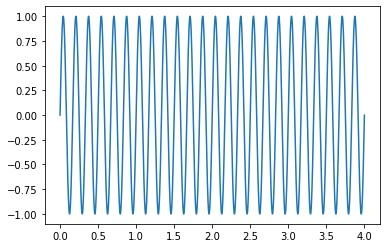

In [20]:
plt.plot(time, mod_signal)

In [21]:
fm_signal = fm_modulator(triangle, carrier_freq, time, sample_rate, mod_signal, mod_amp)


audio = fm_signal * (2**15 - 1) / np.max(np.abs(fm_signal))
audio = audio.astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, sample_rate)

In [33]:
len(time)

176400

In [34]:
len(mod_signal)

176400

## Mozart Sonata no.16 in C

In [170]:
mozart1 = Melody(16, 132)

lead = mozart1.new_voice('lead', instr=triangle)
lead.add_note(1, 2, 'C5', volume=1, profile=long_exp)
lead.add_note(3, 1, 'E5', volume=1, profile=long_exp)
lead.add_note(4, 1, 'G5', volume=1, profile=long_exp)

lead.add_note(5, 1.5, 'B4', volume=1, profile=long_exp)
lead.add_note(6.5, 0.25, 'C5', volume=1, profile=long_exp)
lead.add_note(6.75, 0.25, 'D5', volume=1, profile=long_exp)
lead.add_note(7, 1, 'C5', volume=1, profile=long_exp)

lead.add_note(9, 2, 'A5', volume=1, profile=long_exp)
lead.add_note(11, 1, 'G5', volume=1, profile=long_exp)
lead.add_note(12, 1, 'C6', volume=1, profile=long_exp)

lead.add_note(13, 1, 'G5', volume=1, profile=long_exp)

# Vibrato note as trill
lead.add_vib_note(14, 0.5, 'F5', start=0, width=20, rate=6)
#lead.add_note(14, 0.5, 'F5', volume=1, profile=long_exp)

lead.add_note(14.5, 0.25, 'E5', volume=1, profile=long_exp)
lead.add_note(14.75, 0.25, 'F5', volume=1, profile=long_exp)
lead.add_note(15, 1, 'E5', volume=1, profile=long_exp)


harmony = mozart1.new_voice('harmony', instr=triangle)
harmony.add_note(1, 0.5, 'C4', volume=1, profile=long_exp)
harmony.add_note(1.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(2, 0.5, 'E4', volume=1, profile=long_exp)
harmony.add_note(2.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(3, 0.5, 'C4', volume=1, profile=long_exp)
harmony.add_note(3.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(4, 0.5, 'E4', volume=1, profile=long_exp)
harmony.add_note(4.5, 0.5, 'G4', volume=1, profile=long_exp)

harmony.add_note(5, 0.5, 'C4', volume=1, profile=long_exp)
harmony.add_note(5.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(6, 0.5, 'F4', volume=1, profile=long_exp)
harmony.add_note(6.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(7, 0.5, 'C4', volume=1, profile=long_exp)
harmony.add_note(7.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(8, 0.5, 'E4', volume=1, profile=long_exp)
harmony.add_note(8.5, 0.5, 'G4', volume=1, profile=long_exp)


harmony.add_note(9, 0.5, 'C4', volume=1, profile=long_exp)
harmony.add_note(9.5, 0.5, 'A4', volume=1, profile=long_exp)
harmony.add_note(10, 0.5, 'F4', volume=1, profile=long_exp)
harmony.add_note(10.5, 0.5, 'A4', volume=1, profile=long_exp)
harmony.add_note(11, 0.5, 'C4', volume=1, profile=long_exp)
harmony.add_note(11.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(12, 0.5, 'E4', volume=1, profile=long_exp)
harmony.add_note(12.5, 0.5, 'G4', volume=1, profile=long_exp)


harmony.add_note(13, 0.5, 'B3', volume=1, profile=long_exp)
harmony.add_note(13.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(14, 0.5, 'D4', volume=1, profile=long_exp)
harmony.add_note(14.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(15, 0.5, 'C4', volume=1, profile=long_exp)
harmony.add_note(15.5, 0.5, 'G4', volume=1, profile=long_exp)
harmony.add_note(16, 0.5, 'E4', volume=1, profile=long_exp)
harmony.add_note(16.5, 0.5, 'G4', volume=1, profile=long_exp)

In [171]:
mozart1.add_voice(lead)
mozart1.add_voice(harmony)

In [172]:
mozart1.play()

In [173]:
'''
Second phrase
'''

mozart2 = Melody(32,132)

lead = mozart2.new_voice('lead', instr=triangle)
lead.add_TaDiMi(1, 1, ['A4', 'B4', 'C5'])
lead.add_TaKaDiMi(2, 1, ['D5', 'E5', 'F5', 'G5'])
lead.add_TaKaDiMi(3, 1, ['A5', 'G5', 'F5', 'E5'])
lead.add_TaKaDiMi(4, 1, ['D5', 'C5', 'B4', 'A4'])

lead.add_TaDiMi(5, 1, ['G4', 'A4', 'B4'])
lead.add_TaKaDiMi(6, 1, ['C5', 'D5', 'E5', 'F5'])
lead.add_TaKaDiMi(7, 1, ['G5', 'F5', 'E5', 'D5'])
lead.add_TaKaDiMi(8, 1, ['C5', 'B4', 'A4', 'G4'])

lead.add_TaDiMi(9, 1, ['F4', 'G4', 'A4'])
lead.add_TaKaDiMi(10, 1, ['B4','C5', 'D5', 'E5'])
lead.add_TaKaDiMi(11, 1, ['F5', 'E5', 'D5', 'C5'])
lead.add_TaKaDiMi(12, 1, ['B4', 'A4', 'G4', 'F4'])

lead.add_TaDiMi(13, 1, ['E4', 'F4', 'G4'])
lead.add_TaKaDiMi(14, 1, ['A4', 'B4','C5', 'D5'])
lead.add_TaKaDiMi(15, 1, ['E5', 'D5', 'C5', 'B4'])
lead.add_TaKaDiMi(16, 1, ['A4', 'G4', 'F4', 'E4'])

lead.add_TaDiMi(17, 1, ['D4', 'E4', 'F4'])
lead.add_TaKaDiMi(18, 1, ['G4', 'A4', 'B4','C#5'])
lead.add_TaKaDiMi(19, 1, ['D5', 'A4', 'B4', 'C#5'])
lead.add_TaKaDiMi(20, 1, ['D5', 'E5', 'F5', 'G5'])

lead.add_TaKaDiMi(21, 1, ['A5', 'B5', 'C6', 'B5'])
lead.add_TaKaDiMi(22, 1, ['A5', 'G5', 'F5','E5'])
lead.add_TaKaDiMi(23, 1, ['F5', 'G5', 'A5', 'G5'])
lead.add_TaKaDiMi(24, 1, ['F5', 'E5', 'D5', 'C5'])

lead.add_TaKaDiMi(25, 2, ['D5', 'G5', 'E5', 'C5'])
lead.add_TaKaDiMi(27, 2, ['D5', 'G5', 'E5', 'C5'])

lead.add_TaDi(29, 2, ['D5', 'G5'])
lead.add_note(30, 1, 'D5')
lead.add_note(30, 1, 'B4')
lead.add_note(31, 1, 'G4')

harmony = mozart2.new_voice('harmony1', instr=triangle)
harmony.add_note(1, 1, 'F4')
harmony.add_note(4, 1, 'C4')
harmony.add_note(4, 1, 'F3')

harmony.add_note(5, 1, 'C4')
harmony.add_note(5, 1, 'E3')
harmony.add_note(8, 1, 'C4')
harmony.add_note(8, 1, 'E3')

harmony.add_note(9, 1, 'C4')
harmony.add_note(9, 1, 'D3')
harmony.add_note(12, 1, 'B3')
harmony.add_note(12, 1, 'D3')

harmony.add_note(13, 1, 'C4')
harmony.add_note(13, 1, 'C3')
harmony.add_note(16, 1, 'E3')
harmony.add_note(16, 1, 'C3')

harmony.add_note(17, 4, 'A3')
harmony.add_note(17, 4, 'F3')

harmony.add_TaMi(21, 2, ['F3', 'G3'])
harmony.add_TaMi(23, 2, ['A3', 'F#3'])

harmony.add_TaKaDiMi(25, 1, ['G2', 'B2', 'D3', 'G3'])
harmony.add_TaKaDiMi(26, 1, ['G2', 'C3', 'E3', 'G3'])
harmony.add_TaKaDiMi(27, 1, ['G2', 'B2', 'D3', 'G3'])
harmony.add_TaKaDiMi(28, 1, ['G2', 'C3', 'E3', 'G3'])

harmony.add_TaDi(29, 2, ['G2', 'G3'])
harmony.add_note(31, 1, 'G2')

In [174]:
mozart2.add_voice(lead)
mozart2.add_voice(harmony)

In [175]:
mozart2.play()

In [176]:
'''
B section
'''
mozart3 = Melody(16*4, 132)
right = mozart3.new_voice('right', instr=triangle)
right.add_TaDi(5, 1, ['D6', 'B5'])
right.add_note(6, 1.5, 'G5')
right.add_TaDi(7.5, 0.5, ['A5', 'B5'])
right.add_TaDi(8, 1, ['A5', 'G5'])

right.add_grc_note(9, 0.75, 'G5', 'A5')
right.add_note(9.75, 0.25, 'F#5')
right.add_note(10, 1, 'F#5')

right.add_TaDi(13, 1, ['D6', 'B5'])
right.add_note(14, 1.5, 'G5')
right.add_TaDi(15.5, 0.5, ['A5', 'B5'])
right.add_TaDi(16, 1, ['A5', 'G5'])

right.add_grc_note(17, 0.75, 'G5', 'A5')
right.add_note(17.75, 0.25, 'F#5')
right.add_note(18, 1, 'F#5')


right.add_note(21, 1, 'D6')
right.add_KaDiMi(22, 1, ['D6', 'B5', 'G5'])
right.add_note(23, 1, 'E5')
right.add_KaDiMi(24, 1, ['E5', 'G5', 'E5'])

right.add_note(25, 1, 'C6')
right.add_KaDiMi(26, 1, ['C6', 'A5', 'F#5'])
right.add_note(27, 1, 'D5')
right.add_KaDiMi(28, 1, ['D5', 'F#5', 'D5'])

right.add_note(29, 1, 'B5')
right.add_KaDiMi(30, 1, ['B5', 'G5', 'E5'])
right.add_note(31, 1, 'C5')
right.add_KaDiMi(32, 1, ['C5', 'E5', 'C5'])

right.add_note(33, 1, 'A5')
right.add_KaDiMi(34, 1, ['A5', 'F#5', 'D5'])
right.add_note(35, 1, 'B4')
right.add_KaDiMi(36, 1, ['G5', 'D5', 'B4'])

right.add_note(37, 2, 'A4')
right.add_grc_note(39, 1, 'C5', 'B4')
right.add_grc_note(40, 1, 'E5', 'D#5')


right.add_grc_note(41, 1.5, 'A5', 'G#5')
right.add_TaKaDiMi(42.5, 0.5, ['B5', 'A5', 'G#5', 'A5'])
right.add_TaKaDiMi(43, 2, ['C6', 'A5', 'C6', 'A5'])

right.add_TaDi(45, 1, ['B5', 'G5'])
right.add_note(46, 2, 'D6')
right.add_TaKaDiMi(48, 1, ['C6', 'B5', 'A5', 'G5'])

right.add_vib_note(49, 3.5, 'A5',profile=flat, start=0.1, width=80, rate=6)
right.add_TaDi(52.5, 0.5, ['G5', 'A5'])

right.add_note(53, 1, 'G5')
right.add_TaKaDiMi(54, 1, ['G5', 'D5', 'G5', 'B5'])
right.add_TaKaDiMi(55, 1, ['D6', 'B5', 'G5', 'B5'])
right.add_TaKaDiMi(56, 1, ['C6', 'A5', 'F#5', 'A5'])

right.add_note(57, 1, 'G5')
right.add_TaKaDiMi(58, 1, ['G4', 'D4', 'G4', 'B4'])
right.add_TaKaDiMi(59, 1, ['D5', 'B4', 'G4', 'B4'])
right.add_TaKaDiMi(60, 1, ['C5', 'A4', 'F#4', 'A4'])

right.add_note(61, 1, 'G4')
right.add_note(62, 1, 'B5')
right.add_note(62, 1, 'D5')
right.add_note(63, 1, 'G5')
right.add_note(63, 1, 'B4')



left = mozart3.new_voice('left', instr=triangle)
left.add_TaKaDiMi(1, 1, ['C#4', 'D4', 'C#4', 'D4'])
left.add_TaKaDiMi(2, 1, ['C#4', 'D4', 'C#4', 'D4'])
left.add_TaKaDiMi(3, 1, ['C4', 'D4', 'C4', 'D4'])
left.add_TaKaDiMi(4, 1, ['C4', 'D4', 'C4', 'D4'])

left.add_TaKaDiMi(5, 1, ['B3', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(6, 1, ['B3', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(7, 1, ['B3', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(8, 1, ['B3', 'D4', 'B3', 'D4'])

left.add_TaKaDiMi(9, 1,  ['C4', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(10, 1, ['A3', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(11, 1, ['C4', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(12, 1, ['C4', 'D4', 'A3', 'D4'])

left.add_TaKaDiMi(13, 1, ['B3', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(14, 1, ['B3', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(15, 1, ['B3', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(16, 1, ['B3', 'D4', 'B3', 'D4'])

left.add_TaKaDiMi(17, 1, ['C4', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(18, 1, ['A3', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(19, 1, ['C4', 'D4', 'B3', 'D4'])
left.add_TaKaDiMi(20, 1, ['C4', 'D4', 'A3', 'D4'])

left.add_KaDiMi(21, 1, ['B3', 'D4', 'G4'])
left.add_note(22, 1, 'B4')
left.add_KaDiMi(23, 1, ['C4', 'E4', 'G4'])
left.add_note(24, 1, 'C5')

left.add_KaDiMi(25, 1, ['A3', 'C4', 'F#4'])
left.add_note(26, 1, 'A4')
left.add_KaDiMi(27, 1, ['B3', 'D4', 'F#4'])
left.add_note(28, 1, 'B4')

left.add_KaDiMi(29, 1, ['G3', 'B3', 'E4'])
left.add_note(30, 1, 'G4')
left.add_KaDiMi(31, 1, ['A3', 'C4', 'E4'])
left.add_note(32, 1, 'A4')

left.add_KaDiMi(33, 1, ['F#3', 'A3', 'D4'])
left.add_note(34, 1, 'F#4')
left.add_KaDiMi(35, 1, ['G3', 'B3', 'D4'])
left.add_note(36, 1, 'G4')

left.add_TaKaDiMi(37, 2, 'E4')
left.add_TaKaDiMi(37, 2, 'C4')
left.add_TaKaDiMi(39, 2, 'E4')
left.add_TaKaDiMi(39, 2, 'C4')

left.add_TaKaDiMi(41, 2, 'E4')
left.add_TaKaDiMi(41, 2, 'C4')
left.add_TaKaDiMi(43, 2, 'E4')
left.add_TaKaDiMi(43, 2, 'C4')

left.add_TaKaDiMi(45, 1, ['D4', 'B4', 'G4', 'B4'])
left.add_TaKaDiMi(46, 1, ['D4', 'B4', 'G4', 'B4'])
left.add_TaKaDiMi(47, 1, ['D4', 'B4', 'G4', 'B4'])
left.add_TaKaDiMi(48, 1, ['D4', 'B4', 'G4', 'B4'])

left.add_TaKaDiMi(49, 1, ['D4', 'C5', 'F#4', 'C5'])
left.add_TaKaDiMi(50, 1, ['D4', 'C5', 'F#4', 'C5'])
left.add_TaKaDiMi(51, 1, ['D4', 'C5', 'F#4', 'C5'])
left.add_TaKaDiMi(52, 1, ['D4', 'C5', 'F#4', 'C5'])

left.add_note(53, 1, 'B4')
left.add_note(53, 1, 'G4')
left.add_note(56, 1, 'C5')
left.add_note(56, 1, 'A4')
left.add_note(56, 1, 'D4')

left.add_note(57, 1, 'B4')
left.add_note(57, 1, 'G4')
left.add_note(60, 1, 'C4')
left.add_note(60, 1, 'A3')
left.add_note(60, 1, 'D3')

left.add_note(61, 1, 'B3')
left.add_note(61, 1, 'G3')
left.add_note(62, 1, 'G3')
left.add_note(62, 1, 'G2')
left.add_note(63, 1, 'G3')
left.add_note(63, 1, 'G2')

In [177]:
mozart3.add_voice(right)
mozart3.add_voice(left)

In [117]:
mozart3.play()

In [178]:
mozart = Song([mozart1, mozart2, mozart3])

In [179]:
mozart.play()

In [156]:
mozart.write_to_wav('mozart')

In [ ]:
plt.plot(mozart.waveform)

In [165]:
mozart_rec = Song([mozart1, mozart2])

In [166]:
#mozart_rec.play()

In [167]:
#mozart_rec.write_to_wav('test')

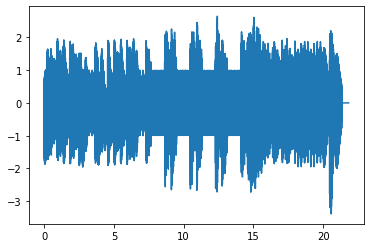

In [169]:
plt.plot(mozart_rec.time, mozart_rec.waveform)